In [1]:
import torch
import torch.nn as nn
# from apex import amp
from torch.cuda import amp
import numpy as np
from tqdm import tqdm
import torch
from torch.nn import functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transforms
from torch.autograd import Variable
from PIL import Image
from matplotlib.pyplot import imshow
from scipy import ndimage as ndi
from skimage.transform import resize
import pandas as pd
import os
import nibabel as nib


import matplotlib.pyplot as plt
%matplotlib inline

%gui qt

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [3]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-smi

Mon May 31 11:02:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:00:05.0 Off |                  N/A |
|  0%   23C    P0    57W / 250W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device= torch.device('cpu')
device

device(type='cuda')

# Import Data

In [5]:
dataDir = 'downloads/OpenDataset/'
# dataDir = 'drive/My Drive/B.Sc proj/OpenDataset/'
metadata = pd.read_csv(dataDir + '201014_M&Ms_Dataset_Information_-_opendataset.csv')
metadata

,External code,VendorName,Vendor,Centre,ED,ES
0,A0S9V9,Siemens,A,1,0,9
1,A1D0Q7,Philips,B,2,0,9
2,A1D9Z7,Siemens,A,1,22,11
3,A1E9Q1,Siemens,A,1,0,9
4,A1K2P5,Canon,D,5,33,11
...,...,...,...,...,...,...
340,T2Z1Z9,Canon,D,5,29,9
341,T9U9W2,Siemens,A,1,0,10
342,V4W8Z5,GE,C,4,19,9
343,W5Z4Z8,Philips,B,2,29,11


In [6]:
def normalize_01(inp: np.ndarray):
    inp_out = (inp - np.min(inp)) / np.ptp(inp)
    return inp_out

def change_sizes(img, diff_seq, is_mask):
    img = img[:,:, diff_seq//2:img.shape[2]-(diff_seq-diff_seq//2)]
    res = []
    for i in range(img.shape[2]):
        x = resize(img[:,:, i], (224,224))
        res.append(x)
    return np.asarray(res)
    
def change_size_and_pad(img, diff_seq):
    res = []
    temp = np.zeros((224, 224))
    temp = temp.astype(np.int)

    for i in range(diff_seq//2):
        res.append(temp)
    for i in range(img.shape[2]):
        x = resize(img[:,:, i], (224,224))
        res.append(x)
    for i in range(diff_seq - diff_seq//2):
        res.append(temp)
    return np.asarray(res)

In [26]:
def save_csv(all_dirs, file_name, addr, save_path):
    cols = ['idx', 'code', 'ED-ES']
    dataframe = pd.DataFrame(columns=cols)
    num_seq = 16
    
    for idx in range(len(all_dirs)):
        
        item = all_dirs[idx]
        path = addr + item

        mask, img, id = None, None, None
        
        image_nif , gt_nif = None, None

        for root, dir, files in os.walk(path):
            for f in files:
                img_arr = nib.load(path + '/' + f).get_fdata()
#                 print(f"file name is {f}")
                if f[-8] == 't':
                    id = f.split('_')[0]
                    mask = img_arr
                    gt_nif = nib.load(path + '/' + f)
                else:
                    img = img_arr
                    image_nif = nib.load(path + '/' + f)
        

        print(f'{idx} out of {len(all_dirs)}')
        
        t = metadata[metadata['External code'] == id]['ES'].iloc[0]
        img1 = img[:, :, :, t]
        gt1 = mask[:, :, :, t]
        
        diff_seq = img1.shape[2] - num_seq
        if diff_seq > 0: 
            img1 = change_sizes(img1, diff_seq, False)
            gt1 = change_sizes(gt1, diff_seq, True)
        else:
#             print(f'BEFORE shape of img is {img.shape} and shape of mask is {gt.shape}')
            img1 = change_size_and_pad(img1, num_seq-img1.shape[2])
            gt1 = change_size_and_pad(gt1, num_seq-gt1.shape[2])
        
        # print(f'AFTER shape of img is {img.shape} and shape of mask is {gt.shape}')
        gt1 = gt1.astype(np.int)

        img1 = normalize_01(img1)
        
        print(image_nif.affine.shape)
        ni_img = nib.Nifti1Image(img1, image_nif.affine)
        formatted_num = str('{:0>4}'.format(idx*2))
        nib.save(ni_img, f'{save_path}/imagesTr/cardiac_{formatted_num}_0000.nii.gz')
        
        ni_mask = nib.Nifti1Image(gt1, gt_nif.affine)
        nib.save(ni_mask, f'{save_path}/labelsTr/cardiac_{formatted_num}.nii.gz')
        
        my_dict = {'idx': idx*2, 'ED-ES': 'ES', 'code': id}
        dataframe = dataframe.append(my_dict, ignore_index=True)
        #####################################################################
        
        t = metadata[metadata['External code'] == id]['ED'].iloc[0]
        img2 = img[:, :, :, t]
        gt2 = mask[:, :, :, t]
      
        diff_seq = img2.shape[2] - num_seq
        if diff_seq > 0: 
            img2 = change_sizes(img2, diff_seq, False)
            gt2 = change_sizes(gt2, diff_seq, True)
        else:
#             print(f'BEFORE shape of img is {img.shape} and shape of mask is {gt.shape}')
            img2 = change_size_and_pad(img2, num_seq-img2.shape[2])
            gt2 = change_size_and_pad(gt2, num_seq-gt2.shape[2])

        gt2 = gt2.astype(np.int)

        # print(f'AFTER shape of img is {img.shape} and shape of mask is {gt.shape}')

        img2 = normalize_01(img2)
        
        
#         print(image_nif.affine.shape)
        ni_img = nib.Nifti1Image(img2, image_nif.affine)
        formatted_num = str('{:0>4}'.format(idx*2 + 1))
        nib.save(ni_img, f'{save_path}/imagesTr/cardiac_{formatted_num}_0000.nii.gz')
        
        ni_mask = nib.Nifti1Image(gt2, gt_nif.affine)
        nib.save(ni_mask, f'{save_path}/labelsTr/cardiac_{formatted_num}.nii.gz')
        
        my_dict = {'idx': idx*2+1, 'ED-ES': 'ED', 'code': id}
        dataframe = dataframe.append(my_dict, ignore_index=True)
    dataframe.to_csv('nnUnet_codes.csv')

In [27]:
save_path = 'nnUNet_raw_data_base/nnUNet_raw_data/Task001_Cardiac'


train_dir = dataDir + '/Training/Labeled/'
train_all = os.listdir(train_dir)[:2]
save_csv(train_all, 'train/train', train_dir, save_path)

0 out of 2
(4, 4)
1 out of 2
(4, 4)


In [25]:
val_dir = dataDir + '/Validation/'
val_all = os.listdir(val_dir)[:5]
save_csv(val_all, 'val/val', val_dir, save_path)

0 out of 5
(4, 4)
1 out of 5
(4, 4)
2 out of 5
(4, 4)
3 out of 5
(4, 4)
4 out of 5
(4, 4)


In [26]:
p = save_path + '/imagesTr/ED-A9J5Q7_0000.nii.gz'
a = nib.load(p).get_fdata()
a.shape

(16, 224, 224)

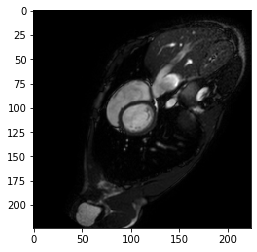

In [27]:
plt.imshow(a[10, :, :], cmap='gray')

In [28]:
p = dataDir + 'Training/Labeled/A9J5Q7/A9J5Q7_sa.nii.gz'
a = nib.load(p).get_fdata()
a.shape

(256, 256, 10, 25)

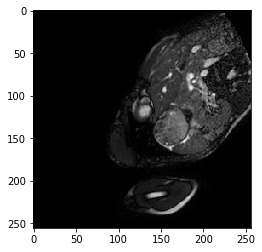

In [29]:
plt.imshow(a[:, :, 1, 1], cmap='gray')

In [28]:

from typing import Tuple
import numpy as np
from batchgenerators.utilities.file_and_folder_operations import *


def get_identifiers_from_splitted_files(folder: str):
    uniques = np.unique([i[:-7] for i in subfiles(folder, suffix='.nii.gz', join=False)])
    return uniques


def generate_dataset_json(output_file: str, imagesTr_dir: str, imagesTs_dir: str, modalities: Tuple,
                          labels: dict, dataset_name: str, license: str = "hands off!", dataset_description: str = "",
                          dataset_reference="", dataset_release='0.0'):
    """
    :param output_file: This needs to be the full path to the dataset.json you intend to write, so
    output_file='DATASET_PATH/dataset.json' where the folder DATASET_PATH points to is the one with the
    imagesTr and labelsTr subfolders
    :param imagesTr_dir: path to the imagesTr folder of that dataset
    :param imagesTs_dir: path to the imagesTs folder of that dataset. Can be None
    :param modalities: tuple of strings with modality names. must be in the same order as the images (first entry
    corresponds to _0000.nii.gz, etc). Example: ('T1', 'T2', 'FLAIR').
    :param labels: dict with int->str (key->value) mapping the label IDs to label names. Note that 0 is always
    supposed to be background! Example: {0: 'background', 1: 'edema', 2: 'enhancing tumor'}
    :param dataset_name: The name of the dataset. Can be anything you want
    :param license:
    :param dataset_description:
    :param dataset_reference: website of the dataset, if available
    :param dataset_release:
    :return:
    """
    train_identifiers = get_identifiers_from_splitted_files(imagesTr_dir)
    print(train_identifiers)

    if imagesTs_dir is not None:
        test_identifiers = get_identifiers_from_splitted_files(imagesTs_dir)
    else:
        test_identifiers = []

    json_dict = {}
    json_dict['name'] = dataset_name
    json_dict['description'] = dataset_description
    json_dict['tensorImageSize'] = "4D"
    json_dict['reference'] = dataset_reference
    json_dict['licence'] = license
    json_dict['release'] = dataset_release
    json_dict['modality'] = {str(i): modalities[i] for i in range(len(modalities))}
    json_dict['labels'] = {str(i): labels[i] for i in labels.keys()}

    json_dict['numTraining'] = len(train_identifiers)
    json_dict['numTest'] = len(test_identifiers)
    json_dict['training'] = [
        {'image': "./imagesTr/%s.nii.gz" % i[:-5], "label": "./labelsTr/%s.nii.gz" % i[:-5]} for i
        in
        train_identifiers]
    json_dict['test'] = ["./imagesTs/%s.nii.gz" % i for i in test_identifiers]

    if not output_file.endswith("dataset.json"):
        print("WARNING: output file name is not dataset.json! This may be intentional or not. You decide. "
              "Proceeding anyways...")
    save_json(json_dict, os.path.join(output_file))

In [29]:
generate_dataset_json(save_path +'/dataset.json', 'nnUNet_raw_data_base/nnUNet_raw_data/Task001_Cardiac/imagesTr/',
                     'nnUNet_raw_data_base/nnUNet_raw_data/Task001_Cardiac/imagesTs', ['MRI'],
                     {0: 'background', 1: 'LV', 2: 'MYO', 3: 'RV'}, 'cardiac-M&M')

['cardiac_0000_0000' 'cardiac_0001_0000' 'cardiac_0002_0000'
 'cardiac_0003_0000']
